In [ ]:
pwd

In [2]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr,kendalltau
from datetime import datetime;now = datetime.now
print(now())

2022-02-22 12:05:14.096030


In [3]:
df = pd.read_csv('../../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:12<00:00, 37.77it/s]


In [7]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
evox = ((flatmap**2).sum(axis=0)!=0)
flatmap = flatmap[:,evox] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
#flatmap = flatmap-flatmap.mean(axis=1)[:,np.newaxis] # center each subject at zero
flatmap.shape

(470, 55432)

In [8]:
mean_J = ims[0].new_image_like(np.array([im.numpy() for im in ims]).mean(axis=0))
mean_J.to_filename('meanJ.nii')

## OVERALL PCA

In [9]:
from sklearn.decomposition import PCA
reducer = PCA()
reducer.fit(flatmap)
j_pca_all = reducer.transform(flatmap)

In [10]:
# Components needed to explain %90 of variance
print((np.cumsum(reducer.explained_variance_ratio_)<.9).sum())

103


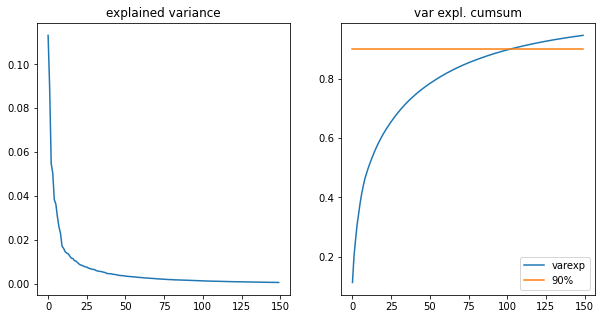

In [11]:
nplot = 150
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(reducer.explained_variance_ratio_[0:nplot])
plt.title('explained variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(reducer.explained_variance_ratio_[0:nplot]))
plt.plot(np.arange(nplot),np.repeat(.9,nplot))
plt.title('var expl. cumsum')
plt.legend(['varexp','90%'])

In [12]:
# LOSO PCA
est_pca = False # Takes a while to run each time, estimate or load precomputed?
if est_pca:
    ns = flatmap.shape[0]
    j_pca_loso = np.array([PCA().fit(flatmap[np.arange(ns)!=s]).transform(flatmap[s,:][np.newaxis,:]) for s in tqdm(range(ns))])
    np.save(file='../../Data/j_pca_loso.npy',arr=j_pca_loso)
else:
    j_pca_loso = np.load('../../Data/j_pca_loso.npy')

j_pca_loso_2 = j_pca_loso[:,0,0:2]

In [13]:
j_pca = j_pca_loso_2 # which PCA to use

In [14]:
#from scipy.stats import pearsonr
corr = kendalltau

In [15]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [16]:
jacobians_flat.shape

(470, 262144)

In [17]:
# DO X AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

100%|██████████| 262144/262144 [01:11<00:00, 3690.69it/s]


In [18]:
# DO Y AXIS
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [01:10<00:00, 3720.41it/s]


In [19]:
# BONF CORRECT MAPS
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()
print(p_thresh)
#print(~np.isnan(xcorr_p).sum())

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

9.020060614807332e-07


In [20]:
(~np.isnan(xcorr_p)).sum()

55432

In [21]:
print((abs(xcorr_r_threshed[xcorr_p<p_thresh])).min()) # minimum x value to be significant
print((abs(ycorr_r_threshed[ycorr_p<p_thresh])).min()) # minimum y value to be significant

0.15162183005942928
0.15161344469350177


In [22]:
# Show tau value ranges (neg and pos)
print((xcorr_r_threshed[xcorr_r_threshed<0].min().round(2),xcorr_r_threshed[xcorr_r_threshed<0].max().round(2)))
print((xcorr_r_threshed[xcorr_r_threshed>0].min().round(2),xcorr_r_threshed[xcorr_r_threshed>0].max().round(2)))

print((ycorr_r_threshed[ycorr_r_threshed<0].min().round(2),ycorr_r_threshed[ycorr_r_threshed<0].max().round(2)))
print((ycorr_r_threshed[ycorr_r_threshed>0].min().round(2),ycorr_r_threshed[ycorr_r_threshed>0].max().round(2)))

(-0.52, -0.15)
(0.15, 0.58)
(-0.45, -0.15)
(0.15, 0.58)


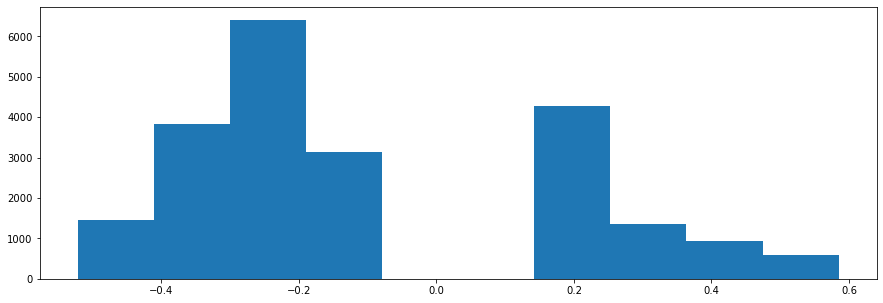

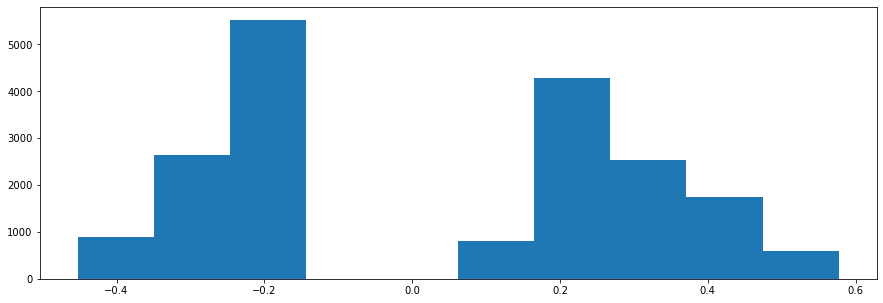

In [23]:
plt.figure(figsize=(15,5));
plt.hist(xcorr_r_threshed);

plt.figure(figsize=(15,5));
plt.hist(ycorr_r_threshed);

In [24]:
temp = ants.image_read('single_subj_T1.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [25]:
# Make nii
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

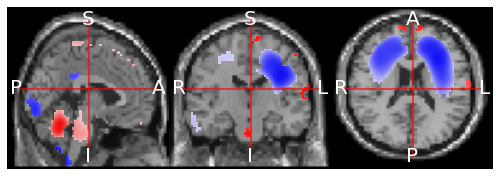

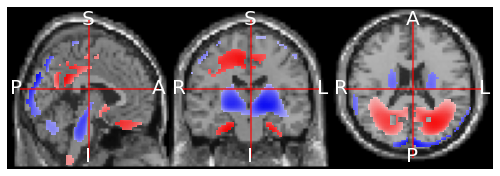

In [26]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [27]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

#ims[0].new_image_like(xcorr_r.reshape((64,64,64))).to_filename('xcorr_pearsonr.nii')
#ims[0].new_image_like(ycorr_r.reshape((64,64,64))).to_filename('ycorr_pearsonr.nii')

#ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))).to_filename('xcorr-bonf_pearsonr.nii')
#ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))).to_filename('ycorr-bonf_pearsonr.nii')

In [28]:
print(np.nanmin(xcorr_r).round(3),np.nanmean(xcorr_r).round(3),np.nanmax(xcorr_r).round(3))
print(np.nanmin(ycorr_r).round(3),np.nanmean(ycorr_r).round(3),np.nanmax(ycorr_r).round(3))

-0.521 -0.045 0.585
-0.453 0.005 0.577


## CORRELATE PCA W/ SYMPTOMS

In [29]:
# CORR PCA W/ SYMOTOMS
#corr = pearsonr
#corr = kendalltau

# keys = ['AgeAtScan','FIQ','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh','ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']

# a = ['DSMIVTR','AgeAtScan', 'Sex', 'FIQ', 'VIQ', 'PIQ', 
#         'ADOS_Total', 
#        'ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB',
#        'ADI_R_Onset Total', 'ADI_R_ResearchReliability',
#         'ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh',
#         'SRS_RawTotal', 'SRS_Version',
#        'SCQ_Total', 'VINELAND_Receptive_Vscore', 'VINELAND_Expressive_Vscore',
#        'VINELAND_Written_Vscore', 'VINELAND_CommunicationStandard',
#        'VINELAND_Personal_Vscore', 'VINELAND_Domestic_Vscore',
#        'VINELAND_Community_Vscore', 'VINELAND_DaylyLiving_Standard',
#        'VINELAND_Interpersonal_Vscore', 'VINELAND_Play_Vscore',
#        'VINELAND_Coping_Vscore', 'VINELAND_Socical_Standard',
#        'VINELAND_Domestic_Standard', 'VINELAND_ABC_Standard',
#      'ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
#        'ADOSGotham_Total', 'ADOSGotham_Severity', 
#        'AQ Total', 'SRS_awareness', 'SRS_cognition', 'SRS_communication',
#        'SRS_motivation', 'SRS_manierisms']

keys = ['ADOS_Comm','ADOS_Social','ADOS_StBeh','AgeAtScan','Sex','FIQ']
npcs = 2 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
for key in keys:
    for i in ['r','p','df']:
        col1.append(key)
        col2.append(i)
#columns = [[key,key],['r','p']]
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

for key in keys:
    for pc in range(npcs):
        vec_behav = df[key].values[patients]
        #vec_pca = j_pca_loso[:,0,pc]
        vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        res_corr.loc[pc].at[(key,'df')] = len(vec_behav[~e])-2
        #res_corr.loc[pc].at[(key,'n')] = len(vec_behav[~e])

In [30]:
pd.options.display.max_columns = None
res_corr

ADOS_Comm                  ADOS_Social                  ADOS_StBeh  \
          r         p     df           r         p     df          r   
0  0.092896  0.017455  342.0    0.056288  0.136015  343.0   0.098143   
1  0.080827  0.038626  342.0   -0.042589  0.259333  343.0  -0.061405   

                   AgeAtScan                        Sex                   \
          p     df         r         p     df         r         p     df   
0  0.023156  283.0  0.057140  0.064370  468.0  0.037782  0.316805  468.0   
1  0.155377  283.0  0.043463  0.159456  468.0  0.007237  0.847932  468.0   

        FIQ                   
          r         p     df  
0  0.004525  0.889681  426.0  
1  0.016245  0.618488  426.0

In [31]:
# make sure Kendall taus are used 
corr

<function scipy.stats.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto')>

In [32]:
these_keys = ['ADOS_Comm','ADOS_Social','ADOS_StBeh','AgeAtScan','Sex','FIQ']
for pc in range(res_corr.shape[0]):
    for key in these_keys:
        p = res_corr[key]['p'][pc]
        r = res_corr[key]['r'][pc]
        dgf = res_corr[key]['df'][pc]
        
        if p < 1:
            print(f'PC{pc} | {key} | $\\tau$({int(dgf)}) = {r:.2f}, p = {p:.3f}')
            #print('PC {} - {} | r = {:.3f},p = {:.3f}'.format(pc,key,res_corr[key]['r'][pc],res_corr[key]['p'][pc]))       
#             if p < .001:
#                 print('pc {}|{}| r({}) = {:.2f}, p = {:.3f}'.format(pc,key,int(res_corr[key]['df'][pc]),res_corr[key]['r'][pc],res_corr[key]['p'][pc]))            
#             else:
#                 print('pc {}|{}| r({}) = {:.2f}, p < .001'.format(pc,key,int(res_corr[key]['df'][pc]),res_corr[key]['r'][pc]))            


PC0 | ADOS_Comm | $\tau$(342) = 0.09, p = 0.017
PC0 | ADOS_Social | $\tau$(343) = 0.06, p = 0.136
PC0 | ADOS_StBeh | $\tau$(283) = 0.10, p = 0.023
PC0 | AgeAtScan | $\tau$(468) = 0.06, p = 0.064
PC0 | Sex | $\tau$(468) = 0.04, p = 0.317
PC0 | FIQ | $\tau$(426) = 0.00, p = 0.890
PC1 | ADOS_Comm | $\tau$(342) = 0.08, p = 0.039
PC1 | ADOS_Social | $\tau$(343) = -0.04, p = 0.259
PC1 | ADOS_StBeh | $\tau$(283) = -0.06, p = 0.155
PC1 | AgeAtScan | $\tau$(468) = 0.04, p = 0.159
PC1 | Sex | $\tau$(468) = 0.01, p = 0.848
PC1 | FIQ | $\tau$(426) = 0.02, p = 0.618


In [33]:
# print(f'{ages_comm.mean():.2f},{ages_comm.std():.2f},{ages_comm.min():.2f},{ages_comm.max():.2f}')
# print(f'{ages_gotham.mean():.2f},{ages_gotham.std():.2f},{ages_gotham.min():.2f},{ages_gotham.max():.2f}')

In [34]:
# arr = np.array([res_corr[key]['r'].values for key in keys])
# plt.figure(figsize=(15,5))
# o = np.argsort(arr[:,0]-arr[:,1])
# plt.plot(arr[o,:],'x')
# plt.xticks(np.arange(len(o)),labels=np.array(keys)[o],rotation=90);

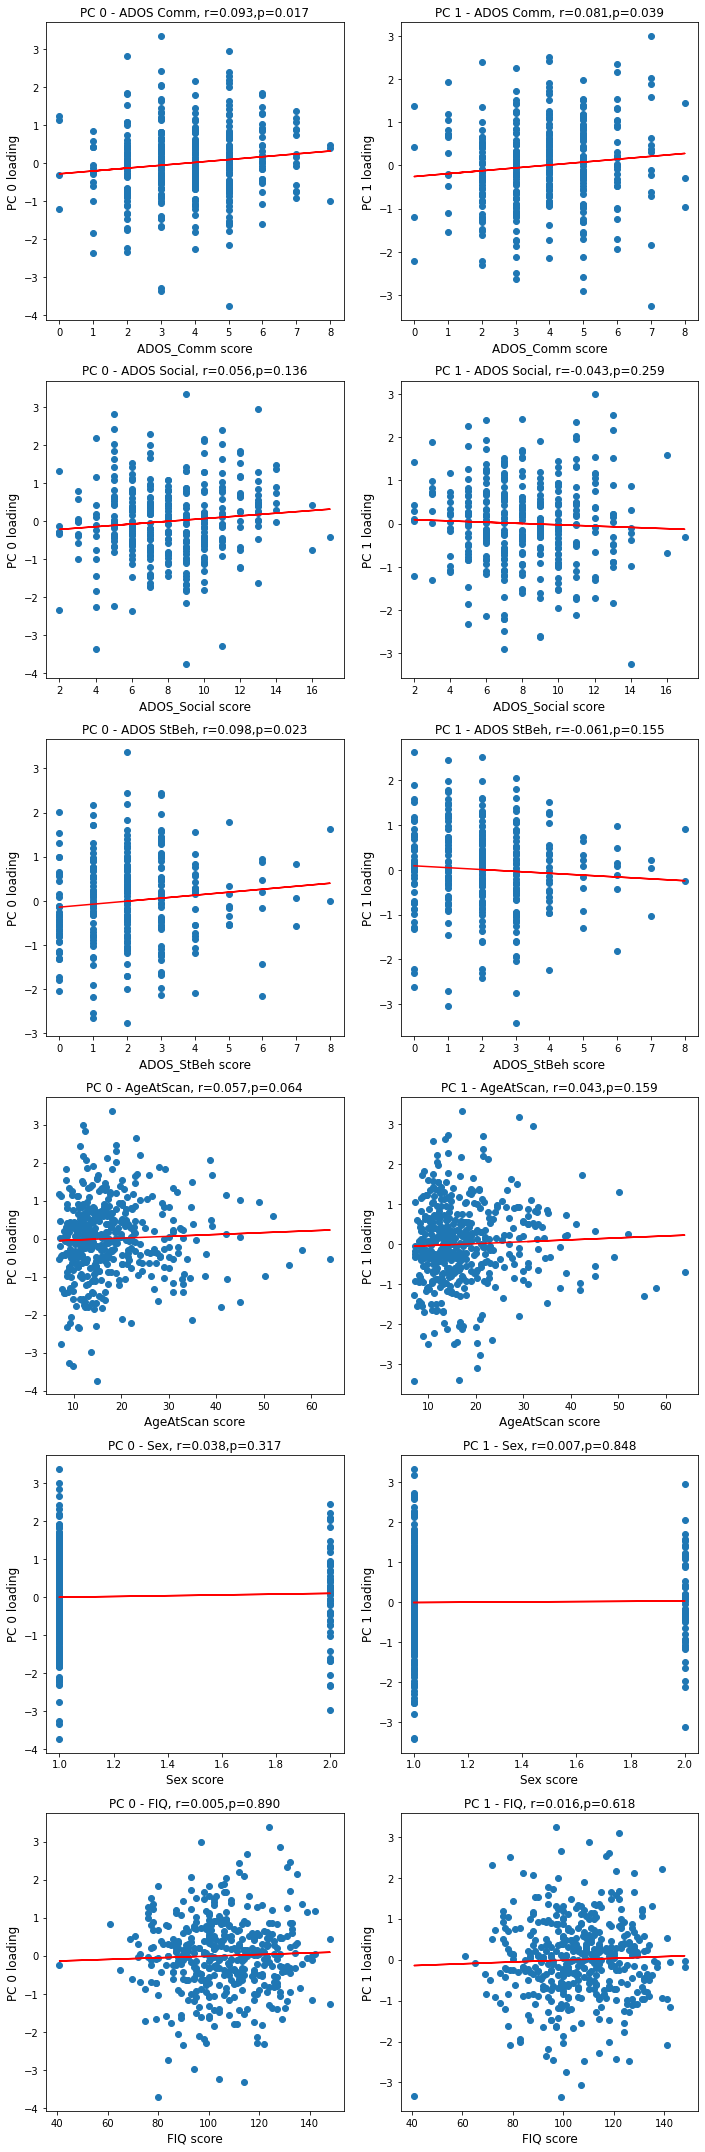

In [35]:
these_pcs = 2
# these_keys = ['ADOS_Comm','ADOS_StBeh','ADOSGotham_Rest-RepBeh','ADOSGotham_Total','ADOSGotham_SocAffect','ADOSGotham_Severity'
#              ,'VINELAND_Receptive_Vscore'
#              ,'VINELAND_CommunicationStandard'
#              ,'VINELAND_Domestic_Standard','VINELAND_Socical_Standard']

these_keys = keys

#these_keys = ['ADOS_Comm','ADOS_StBeh']

i = 0
plt.figure(figsize=(10,5*len(these_keys)))
for key in these_keys:
    for pc in range(these_pcs):
        i+=1
        plt.subplot(len(these_keys),2,i)
        vec_behav = df[key].values[patients]
        vec_pca = j_pca[:,pc]
        e = np.isnan(vec_behav)

        import scipy

        v1 = vec_behav[~e]
        v2 = j_pca[~e,pc]

        #v1 = scipy.stats.zscore(v1)
        v2 = scipy.stats.zscore(v2)

        x = v1
        y = v2
        m, b = np.polyfit(x,y, 1)
        plt.scatter(v1,v2)
        plt.plot(x, m*x + b,'r')
        plt.xlabel(f'{key} score',fontsize=12)
        plt.ylabel(f'PC {pc} loading',fontsize=12)

        rval = res_corr[key]['r'][pc]
        pval = res_corr[key]['p'][pc]
        this_key = key.replace('_',' ')
        plt.title(f'PC {pc} - {this_key}, r={rval:.3f},p={pval:.3f}')
        
plt.tight_layout()

In [36]:
# vec_behav = df['VINELAND_Socical_Standard'].values[patients]
# vec_behav[vec_behav<50]=np.nan
# vec_pca = j_pca[:,0]
# e = np.isnan(vec_behav)
# r,p = corr(vec_behav[~e],vec_pca[~e])

# v1 = vec_behav[~e]
# v2 = j_pca[~e,pc]

# #v1 = scipy.stats.zscore(v1)
# v2 = scipy.stats.zscore(v2)

# x = v1
# y = v2
# m, b = np.polyfit(x,y, 1)
# plt.scatter(v1,v2)
# plt.plot(x, m*x + b,'r')
# plt.xlabel(f'{key} score',fontsize=12)
# plt.ylabel(f'PC {pc} loading',fontsize=12)
# (r,p)

In [37]:
c1 = ants.image_read('../../Data/c1Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)
c2 = ants.image_read('../../Data/c2Atlas_brain_2mm.nii').resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [38]:
xcorr_r_nii = ims[0].new_image_like(xcorr_r.reshape((64,64,64)))# .to_filename('xcorr.nii')
ycorr_r_nii = ims[0].new_image_like(ycorr_r.reshape((64,64,64)))# .to_filename('ycorr.nii')

xcorr_r_threshed_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64)))# .to_filename('xcorr-bonf.nii')
ycorr_r_threshed_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64)))# .to_filename('ycorr-bonf.nii')

In [39]:
xcorr_r_nii_nii_pos = xcorr_r_nii.copy()
xcorr_r_nii_nii_neg = xcorr_r_nii.copy()
xcorr_r_nii_nii_pos[xcorr_r_nii<0] = 0
xcorr_r_nii_nii_neg[xcorr_r_nii>0] = 0

ycorr_r_nii_nii_pos = ycorr_r_nii.copy()
ycorr_r_nii_nii_neg = ycorr_r_nii.copy()
ycorr_r_nii_nii_pos[ycorr_r_nii<0] = 0
ycorr_r_nii_nii_neg[ycorr_r_nii>0] = 0

xcorr_r_nii_nii_neg = xcorr_r_nii_nii_neg.new_image_like(abs(xcorr_r_nii_nii_neg.numpy()))
ycorr_r_nii_nii_neg = ycorr_r_nii_nii_neg.new_image_like(abs(ycorr_r_nii_nii_neg.numpy()))

xcorr_r_nii_nii_pos[np.isnan(xcorr_r_nii_nii_pos.numpy())] = 0
xcorr_r_nii_nii_neg[np.isnan(xcorr_r_nii_nii_neg.numpy())] = 0
ycorr_r_nii_nii_pos[np.isnan(ycorr_r_nii_nii_pos.numpy())] = 0
ycorr_r_nii_nii_neg[np.isnan(ycorr_r_nii_nii_neg.numpy())] = 0

xcorr_r_nii_nii_pos.to_filename('pos-xcorr2.nii')
xcorr_r_nii_nii_neg.to_filename('neg-xcorr2.nii')
ycorr_r_nii_nii_pos.to_filename('pos-ycorr2.nii')
ycorr_r_nii_nii_neg.to_filename('neg-ycorr2.nii')

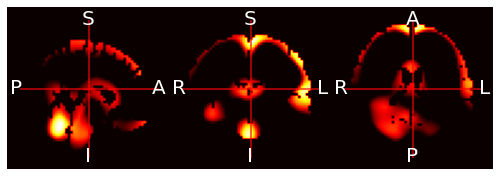

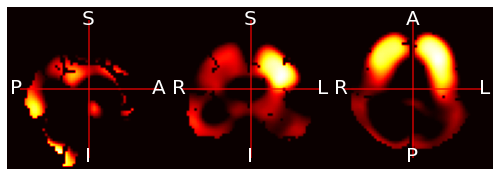

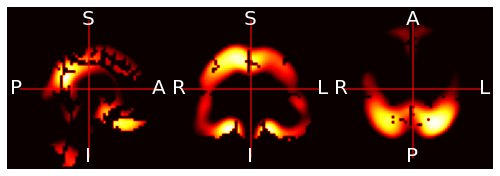

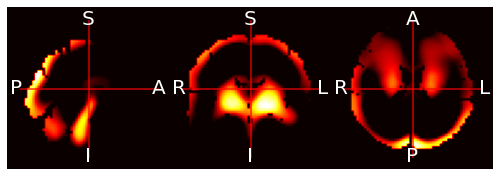

In [40]:
xcorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
xcorr_r_nii_nii_neg.plot_ortho(flat=True,cmap='hot')

ycorr_r_nii_nii_pos.plot_ortho(flat=True,cmap='hot')
ycorr_r_nii_nii_neg.plot_ortho(flat=True,cmap='hot')

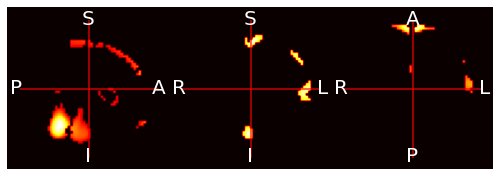

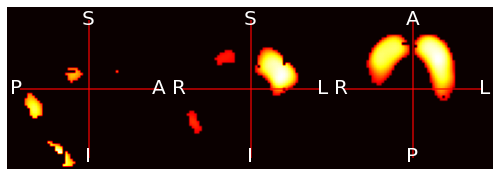

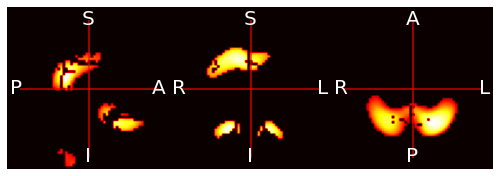

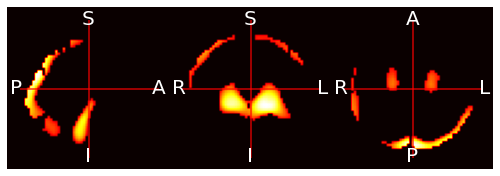

In [41]:
xcorr_r_threshed_nii_pos = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_nii_pos[xcorr_r_threshed_nii_pos<0] = 0
xcorr_r_threshed_nii_neg[xcorr_r_threshed_nii_neg>0] = 0

ycorr_r_threshed_nii_pos = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_nii_pos[ycorr_r_threshed_nii_pos<0] = 0
ycorr_r_threshed_nii_neg[ycorr_r_threshed_nii_neg>0] = 0


ycorr_r_threshed_nii_neg = ycorr_r_threshed_nii_neg.new_image_like(abs(ycorr_r_threshed_nii_neg.numpy()))
xcorr_r_threshed_nii_neg = xcorr_r_threshed_nii_neg.new_image_like(abs(xcorr_r_threshed_nii_neg.numpy()))

xcorr_r_threshed_nii_pos.to_filename('pos-xcorr_pearsonr.nii')
xcorr_r_threshed_nii_neg.to_filename('neg-xcorr-bonf_pearsonr.nii')
ycorr_r_threshed_nii_pos.to_filename('pos-ycorr-bonf_pearsonr.nii')
ycorr_r_threshed_nii_neg.to_filename('neg-ycorr-bonf_pearsonr.nii')


xcorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
xcorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

ycorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
ycorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

In [42]:
xcorr_r_threshed_gm_nii = xcorr_r_threshed_nii.copy()
xcorr_r_threshed_wm_nii = xcorr_r_threshed_nii.copy()

ycorr_r_threshed_gm_nii = ycorr_r_threshed_nii.copy()
ycorr_r_threshed_wm_nii = ycorr_r_threshed_nii.copy()

In [43]:
xcorr_r_threshed_gm_nii[c1<.9]=0
xcorr_r_threshed_wm_nii[c2<.9]=0

ycorr_r_threshed_gm_nii[c1<.9]=0
ycorr_r_threshed_wm_nii[c2<.9]=0

In [44]:
xcorr_r_threshed_gm_nii.to_filename('xcorr-bonf-gm_pearsonr.nii')
xcorr_r_threshed_wm_nii.to_filename('xcorr-bonf-wm_pearsonr.nii')

ycorr_r_threshed_gm_nii.to_filename('ycorr-bonf-gm_pearsonr.nii')
ycorr_r_threshed_wm_nii.to_filename('ycorr-bonf-wm_pearsonr.nii')

In [46]:
# xcorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
# xcorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

# ycorr_r_threshed_nii_pos.plot_ortho(flat=True,cmap='hot')
# ycorr_r_threshed_nii_neg.plot_ortho(flat=True,cmap='hot')

In [47]:
jacobians_flat.shape

(470, 262144)

In [48]:
xcorr_r_threshed_nii_pos.numpy().flatten().shape

(262144,)

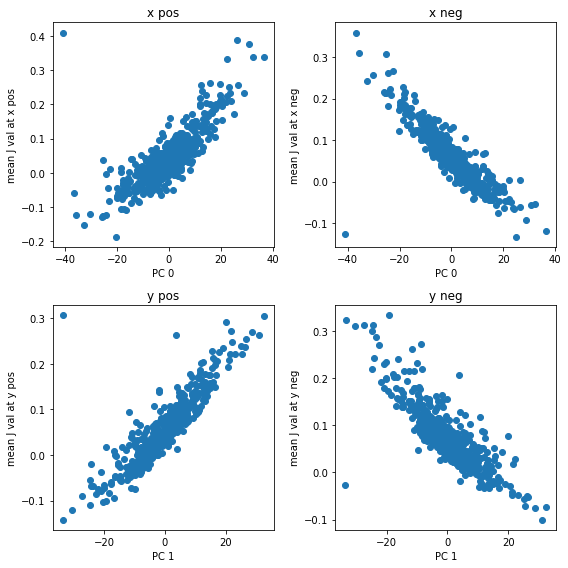

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
v1=j_pca[:,0]
v2=jacobians_flat[:,xcorr_r_threshed_nii_pos.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 0')
plt.ylabel('mean J val at x pos')
plt.title('x pos')

plt.subplot(2,2,2)
v1=j_pca[:,0]
v2=jacobians_flat[:,xcorr_r_threshed_nii_neg.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 0')
plt.ylabel('mean J val at x neg')
plt.title('x neg')

plt.subplot(2,2,3)
v1=j_pca[:,1]
v2=jacobians_flat[:,ycorr_r_threshed_nii_pos.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 1')
plt.ylabel('mean J val at y pos')
plt.title('y pos')

plt.subplot(2,2,4)
v1=j_pca[:,1]
v2=jacobians_flat[:,ycorr_r_threshed_nii_neg.numpy().flatten()>0.01].mean(axis=1)
plt.scatter(v1,v2)
plt.xlabel('PC 1')
plt.ylabel('mean J val at y neg')
plt.title('y neg')

plt.tight_layout()

(array([  9.,  69., 184., 117.,  59.,  21.,   7.,   2.,   1.,   1.]),
 array([-0.0074505 ,  0.01352595,  0.03450239,  0.05547883,  0.07645528,
         0.09743172,  0.11840817,  0.13938461,  0.16036105,  0.1813375 ,
         0.20231394], dtype=float32),
 <BarContainer object of 10 artists>)

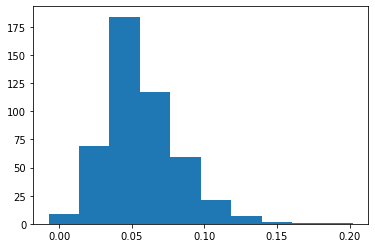

In [50]:
plt.hist(jacobians_flat[:,~np.isnan(xcorr_p)].mean(axis=1))

In [51]:
ants.__version__

'0.2.4'

In [52]:
print(now())

2022-02-22 12:08:02.429996
